<a href="https://colab.research.google.com/github/akrawat912/Deep-Learning/blob/master/fine_tuned_BERT_with_IMDB_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# for uploading kaggle.json file
# it has kaggle user_name and unique key to all kaggle users for interacting with kaggle
from google.colab import files
files.upload()

In [4]:
# install the Kaggle API client.
!pip install -q kaggle

In [6]:
!cp kaggle.json ~/.kaggle/
# changing permission
!chmod 600 ~/.kaggle/kaggle.json
#download dataset from kaggle 
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# create new dir to extract .zip
!mkdir imdb_reviews
# unzipping into fruits directory
!unzip -uq imdb-dataset-of-50k-movie-reviews.zip -d imdb_reviews

In [8]:
from glob import glob
glob('imdb_reviews/*')

['imdb_reviews/IMDB Dataset.csv']

In [9]:
import pandas as pd
import numpy as np
import re

In [172]:
data = pd.read_csv('imdb_reviews/IMDB Dataset.csv', nrows=10000)
data.head(5)

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,1,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,1,A wonderful little production. The filming tec...
2,I thought this was a wonderful way to spend ti...,1,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,0,Basically theres a family where a little boy (...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"Petter Matteis ""Love in the Time of Money"" is ..."


In [45]:
data.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [46]:
# target class positive as 1, negative as 0
data.sentiment = data.sentiment.map({'positive':1, 'negative':0})
data.sentiment.unique()

array([1, 0])

In [13]:
data['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [14]:
print('no. of samples: ',data.shape[0])

no. of samples:  50000


### PREPROCESSING reviews

In [47]:
def text_preprocessing(text):
    """
    - Remove <br/>  tags
    - Correct errors (eg. I\'d, \'s, \'ve)
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '<br/>'
    text = re.sub(r'(<br />*)', ' ', text)

    text = re.sub(r'(\'+)', '', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [48]:
data['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [49]:
text_preprocessing(data['review'][2])

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love. This was the most Id laughed at one of Woodys comedies in years (dare I say a decade?). While Ive never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman. This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [50]:
# cleaning reviews
data['clean_review'] = data['review'].map(lambda a: text_preprocessing(a))

In [51]:
data.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,1,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,1,A wonderful little production. The filming tec...
2,I thought this was a wonderful way to spend ti...,1,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,0,Basically theres a family where a little boy (...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"Petter Matteis ""Love in the Time of Money"" is ..."


In [52]:
# Get the lists of sentences and their labels.
sentences = data.clean_review.values
labels = data.sentiment.values

### Tokenization & Input Formatting

In [53]:
!pip install transformers

In [54]:
from transformers import BertTokenizer
import torch

In [55]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [56]:
# example tokenizer
# Print the original sentence.
print('Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked. They are right, as this is exactly what happened with me. The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word. It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. I would say the main appeal of the show is due to the fact that it goes where ot

In [114]:
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts(sentences) to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=128,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask
            truncation=True
            )
        
        # Add the encoded sentence to the list.
        input_ids.append(encoded_sent['input_ids'])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_sent['attention_mask'])
      # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [115]:
# Print sentence 0 and its encoded token ids
token_ids = preprocessing_for_bert([sentences[0]])[0]
print('Original: ', sentences[0])
print('Token IDs: ', token_ids)

Original:  One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked. They are right, as this is exactly what happened with me. The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word. It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. I would say the main appeal of the show is due to the fact that it goes where ot

In [116]:
# 0's are padded to max_len, This mask tells the “Self-Attention” mechanism in BERT not to
# incorporate these PAD tokens into its interpretation of the sentence.

In [117]:
input_ids, attention_masks = preprocessing_for_bert(sentences)
labels = torch.tensor(labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [118]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


### Training & Validation Split

In [119]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

9,000 training samples
1,000 validation samples


In [120]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
batch_size = 32
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### Training

In [122]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [123]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [132]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [133]:
set_seed()    # Set seed for reproducibility, default 42
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, validation_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.603416   |     -      |     -     |   27.44  
   1    |   40    |   0.392103   |     -      |     -     |   26.13  
   1    |   60    |   0.368296   |     -      |     -     |   26.07  
   1    |   80    |   0.352462   |     -      |     -     |   26.04  
   1    |   100   |   0.361095   |     -      |     -     |   26.03  
   1    |   120   |   0.398871   |     -      |     -     |   26.05  
   1    |   140   |   0.313055   |     -      |     -     |   25.99  
   1    |   160   |   0.379125   |     -      |     -     |   26.04  
   1    |   180   |   0.342183   |     -      |     -     |   26.00  
   1    |   200   |   0.360162   |     -      |     -     |   26.01  
   1    |   220   |   0.284981   |     -      |     -     |   26.00  
   1    |   240   |   0.319527   |     -      |     -     |   26.02  


### Prediction

In [138]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

### Prediction on unseen data

In [173]:
# we get first 10k samples for train and validation, we getting last 5k sample which is unseen
test_df = pd.read_csv('imdb_reviews/IMDB Dataset.csv', ).tail(5000)

In [182]:
test_df = test_df.reset_index()
del(test_df['index'])
test_df.head()

,review,sentiment
0,What I enjoyed most in this film was the scene...,positive
1,MacArthur is a great movie with a great story ...,positive
2,What can I say? I ignored the reviews and went...,negative
3,A pretty transparent attempt to wring cash out...,negative
4,Even though the book wasn't strictly accurate ...,negative


In [183]:
# cleaning reviews
test_df['clean_review'] = test_df['review'].map(lambda a: text_preprocessing(a))

In [197]:
test_df.sentiment = test_df.sentiment.map({'positive':1, 'negative':0})

In [184]:
sent_to_predict = test_df.clean_review.values

In [185]:
ip_ids, att_masks = preprocessing_for_bert(sent_to_predict)

In [188]:
test_dataset = TensorDataset(ip_ids, att_masks)
test__dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [190]:
# predicting
probs = bert_predict(bert_classifier, test__dataloader)

In [199]:
def accuracy_score(y_true, y_pred):
  """custom function to calculate accuracy between binary classes """
  return (y_true == y_pred).sum() / float(len(y_true))

In [200]:
y_pred = [np.argmax(i) for i in probs] # predicted class 
y_true = test_df.iloc[:,1].values #actual class, 1 index is of 'sentiment' column.

accuracy_score(y_true, y_pred)

0.8786

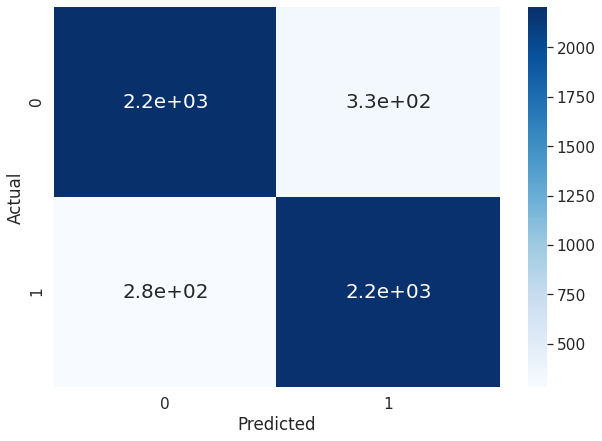

In [211]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
data = confusion_matrix(y_true, y_pred) 
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 20})
plt.show()

In [210]:
df_cm
# our model predict 2204 FN and 2189 FP

Predicted,0,1
Actual,,
0,2204,326
1,281,2189
